# Assignment 3

As we are now getting into actually preforming Bayesian Optimization, it is a good idea to begin to familiarize yourself with a Bayesian Optimization library, as opposed to coding everything strictly in Numpy. I have found BoTorch to be a very intuitive, scalable, and fast library. What follows is a full noisy bayesian batch optimization loop in BoTorch and a comparison of the efficacy of different acquisition functions (with random acquisition as a basline comparison). It will be your job to analyze the code, understand what is happening, fill in some missing code, and answer some questions regarding the setup of the optimization loop at the end.

Note: this BO loop could be greatly condensed by using Ax's SimpleExperiment API as this example is fairly simple, but I feel that it is better to see all the parts in a lower-level implementation before moving on to using Ax, as there will be times where you may want to preform tasks that ae not supported in Ax. 

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

## Objective function

The underlying objectve function we wish to predict will be the negated 6-dimensional Hartmann function, which BoTorch includes as one of its test functions. The (non-negated) hartmann function is defined as follows:

\begin{equation}
f(x)=-\sum_{i=1}^4\alpha_i\exp(-\sum_{j=1}^6A_{ij}(x_j-P_{ij})^2)
\end{equation}
Where
\begin{equation}
\alpha=(1.0,1.2,3.0,3.2)^T
\end{equation}
\begin{equation}
A = \begin{bmatrix}
10 & 3 & 17 & 3.5 & 1.7 & 8\\ 
0.05 & 10 & 17 & 0.1 & 8 & 14\\ 
3 & 3.5 & 1.7 & 10 & 17 & 8\\ 
17 & 8 & 0.05 & 10 & 0.1 & 14
\end{bmatrix}
\end{equation}
\begin{equation}
P = 10^{-4}\begin{bmatrix}
1312 & 1696 & 5569 & 124 & 8283 & 5886\\ 
2329 & 4135 & 8307 & 3736 & 1004 & 9991\\ 
2348 & 1451 & 3522 & 2883 & 3047 & 6650\\ 
4047 & 8828 & 8732 & 5743 & 1091 & 381
\end{bmatrix}
\end{equation}

The domain is the unit hypercube \[0,1\]^6, and the function has 5 local minima and a global minimum of -3.32237 at (0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573).

We now define our objective function, add a synthetic constraint of the form ||x||<sub>1</sub>-3 <= 0, and define a "feasibility-weighted objective" function which retuns 0 if the input X to the objective is not feasible in terms of the constraint.

In [3]:
from botorch.test_functions import Hartmann

neg_hartmann6 = Hartmann(negate=True)

def outcome_constraint(X):
    return X.sum(dim=-1) - 3

def weighted_obj(X):
    return neg_hartmann6(X) * (outcome_constraint(X) <= 0).type_as(X)

## Initializing the model

We will use a multi output Gaussian Proccess to model the objective and constraint (outputs 0 and 1, respectively). This is done by creating a BoTorch FixedNoiseGP (with standard noide parameter of 0.5) for each of these two components and combining them with a ModelListGP. We also require a function to initialize the models, so we define generate_initial_data to create our initial training and testing data for both components by randomly sampling n=10 points from the domain (with noise), evaluating them on our weighted objective and the constraint, and returning this data along with the best observed value.

It is your job to fill in the init_model function.

Note: I have left the model initialization task to you in order to increase your comfortability with initializing BoTorch models, but the real meat of this assignment is in understanding the decisions made throughout the BO process and seeing the final BO loop work properly. So, if you can't figure out this part in a reasonable amount of time, don't be afraid to reach out to me over Slack, as the main BO loop will not work without this function.

In [8]:
from botorch.models import FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

stdErrNoise = 0.5
train_y_var = torch.tensor(stdErrNoise**2, device=device, dtype=dtype)

def generate_initial_data(n=10):
    train_x = torch.rand(n,6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)
    exact_con = outcome_constraint(train_x).unsqueeze(-1)
    train_obj = exact_obj + stdErrNoise * torch.randn_like(exact_obj)
    train_con = exact_con + stdErrNoise * torch.randn_like(exact_con)
    
    best_obs_val = weighted_obj(train_x).max().item()
    return train_x, train_obj, train_con, best_obs_val



def init_model(train_x, train_obj, train_con, state_dict=None):
    """
    FixedNoiseGP Required Params:
        train_X (Tensor) – A batch_shape x n x d tensor of training features.
        train_Y (Tensor) – A batch_shape x n x m tensor of training observations.
        train_Yvar (Tensor) – A batch_shape x n x m tensor of observed measurement noise.
    ModelListGP takes in models as *args
    """
    
    """
    Requirements:
        -Create a FixedNoiseGP for both the objective and the constraint
            -Hint: make sure to get train_y_var (defined above) into the correct
                    shape for each component model
        -Create a ModelListGP with the objective and constraint GPs as components
            0 and 1, respectively
        -Create a SumMarginalLogLikelihood object using your model to act as
            the loss for your model
        -Return your model and the MLL object
    
    """
    model_obj = # TODO
    model_con = # TODO
    
    model = # TODO
    mll = # TODO
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    return mll, model

## Defining objective for optimization

Here we define a constrained objective using the BoTorch ConstrainedMCObjective object. This is a feasibility-weighted objective that allows us to maximize some scalable objective on the model outputs subject to a number of constraints. It takes in as parameters a callable that maps a sample-shape x batch-shape x q x m-dimensional tensor to a sample-shape x batch-shape x q-dimensional tensor of objective values, as well as a list of callables that do the same mapping but to our constraint values.

We never actually call either of these functions directly. constrained_obj is passed into our acquisition functions later-on during the optimization step as the objective under which the samples are evaluated.

In [6]:
from botorch.acquisition.objective import ConstrainedMCObjective

def obj_callable(Z):
    return Z[...,0]
def constraint_callable(Z):
    return Z[...,1]

constrained_obj = ConstrainedMCObjective(
    objective=obj_callable,
    constraints=[constraint_callable]
)

## Defining helper functions for optimization setup

We must now define a function that takes in an acquisition function as an argument, optimizes it using BoTorch's optimize_acqf, generates new values to continue training the model with, and returns the new candidate batch {x1,x2,...xq} (q=batch_sz=3 in our case) along with (noisy) observed objective values. We also define a function to simulate a random observation policy, which we will use when we compare our final results.

Note: optimize_acqf uses multi-start optimization under the hood via scipy.optimize.minimize() (L-BFGS-B or SLSQP) and automatically handles the conversion between torch and numpy types, while taking advantage of PyTorch's autograd capabilities to accelerate optimization. This is one of the extremely convenient things about BoTorch, as trying to use SciPy optimizers on Tensors manually is very annoying (I have experienced this first-hand in other side projects). BoTorch also allows for using torch optimizers and even custom optimization functions.

In [7]:
from botorch.optim import optimize_acqf

batch_sz = 3
bounds = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)

def optimize_acqf_get_obs(acq_fn):
    
    # Optimize the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=acq_fn,
        bounds=bounds,
        q=batch_sz,
        num_restarts=10,
        raw_samples=512, # used for initialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    
    # observe new values
    new_x = candidates.detach()
    exact_obj = neg_hartmann6(new_x).unsqueeze(-1)
    exact_con = outcome_constraint(new_x).unsqueeze(-1)
    new_obj = exact_obj + stdErrNoise * torch.randn_like(exact_obj)
    new_con = exact_con + stdErrNoise * torch.randn_like(exact_con)
    return new_x, new_obj, new_con


def update_random_obs(best_rand):
    """
    Simulates random policy by taking the current list of best values observed
    randomly, drawing new random point, observing its value, and updating the list
    """
    rand_x = torch.rand(batch_sz, 6)
    next_rand_best = weighted_obj(rand_x).max().item()
    best_rand.append(max(best_rand[-1], next_rand_best))
    return best_random

## Performing Bayesian optimization (finally)

We now define our Bayesian optimization loop, and preform optimization of our models and acquisition functions and observations of our best values for each iteration. The general model for a batch BO loop with batch size of q is as follows:

1. Given surrogate model (the model returned by init_model), fit the model to the initial (or current, if past the first iteration) training data, and choose batch of points {x1,...,xq} using the acquisition function
2. Observe f(x) for each x in the batch, and add these new observations to the training data
3. Update the surrogate model for the next iteration

We run 3 trials (outer for-loop) of this optimization loop and save all of their results. Within each trial, we first call our helper functions to generate initial training data and initialize 2 surrogate models, one of which will use the Expected Improvement acquisition function while the other uses Noisy Expected Improvement, and then we do numBatches=20 rounds of optimization on these models. 

Note: we aren't actually using vanilla EI and NEI acquisition functions, and instead are using quasi-EI and quasi-NEI. The vanilla versions of these acquisition functions rely on the posterior at a single test point being Gaussian and only support the case of q=1. We have q=3 and a joint posterior, so we use the quasi versions, which are Monte-Carlo-based batch acquisition functions. These compute their respective acqisition function by sampling the joint posterior over q points, evaluating the improvement over the current best for each sample, maximizing over q, and averaging over the samples.

Within each round of observation, we fit our surrogate models to the current training data and define our acquisition functions on the models, a SobolQMCNormalSampler with 256 samples, and the objective (constrained_obj) we defined earlier. We then optimize the acquisition functions and get the new observations using our helper function, append the new observations to the training data, save the best observed values for each model (and a random observation), and re-initialize our models (this time, we pass in the state dict to speed up optimization).

In [ ]:
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning, InputDataWarning
import time

import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=InputDataWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

N = 10
numTrials = 3
numBatches = 20
mcSamples = 256

verbose = False

best_observed_all_EI, best_observed_all_NEI, best_random_all = [], [], []

# Average over multiple trials
for trial in range(1,numTrials+1):
    print(f"\nTrial {trial:>2} of {numTrials} ", end="")
    best_observed_EI, best_observed_NEI, best_random = [], [], []
    
    train_x_EI, train_obj_EI, train_con_EI, best_observed_val_EI = generate_initial_data(N)
    mll_EI, model_EI = init_model(train_x_EI, train_obj_EI, train_con_EI)
    
    train_x_NEI, train_obj_NEI, train_con_NEI = train_x_EI, train_obj_EI, train_con_EI
    best_observed_val_NEI = best_observed_val_EI
    mll_NEI, model_NEI = init_model(train_x_NEI, train_obj_NEI, train_con_NEI)
    
    best_observed_EI.append(best_observed_val_EI)
    best_observed_NEI.append(best_observed_val_NEI)
    best_random.append(best_observed_val_EI)
    
    # Run numBatches rounds of Bayesian Optimization afer initial random batch
    for iteration in range(1,numBatches+1):
        t0 = time.time()
        
        # fit models
        fit_gpytorch_model(mll_EI)
        fit_gpytorch_model(mll_NEI)
        
        # define EI and NEI acquisition modules using QMC sampler
        qmc_sampler = SobolQMCNormalSampler(num_samples=mcSamples)
        
        # for best f (best obj val observed so far) use best observed noisy value as approx.
        EI = qExpectedImprovement(
            model=model_EI,
            best_f=(train_obj_EI * (train_con_EI <= 0).to(train_obj_EI)).max(),
            sampler=qmc_sampler,
            objective=constrained_obj,
        )
        
        NEI = qNoisyExpectedImprovement(
            model=model_NEI,
            X_baseline=train_x_NEI,
            sampler=qmc_sampler,
            objective=constrained_obj,
        )
        
        # optimize and get new observation
        new_x_EI, new_obj_EI, new_con_EI = optimize_acqf_get_obs(EI)
        new_x_NEI, new_obj_NEI, new_con_NEI = optimize_acqf_get_obs(NEI)
        
        # Update training points
        train_x_EI = torch.cat([train_x_EI, new_x_EI])
        train_obj_EI = torch.cat([train_obj_EI, new_obj_EI])
        train_con_EI = torch.cat([train_con_EI, new_con_EI])
        
        train_x_NEI = torch.cat([train_x_NEI, new_x_NEI])
        train_obj_NEI = torch.cat([train_obj_NEI, new_obj_NEI])
        train_con_NEI = torch.cat([train_con_NEI, new_con_NEI])
        
        # Update progress
        best_random = update_random_obs(best_random)
        best_value_EI = weighted_obj(train_x_EI).max().item()
        best_value_NEI = weighted_obj(train_x_NEI).max().item()
        best_observed_EI.append(best_value_EI)
        best_observed_NEI.append(best_value_NEI)
        
        # Reinit. models for fitting on next iter. Use current state dict to accelerate fitting
        mll_EI, model_EI = init_model(
            train_x_EI,
            train_obj_EI,
            train_con_EI,
            model_EI.state_dict(),
        )
        
        mll_NEI, model_NEI = init_model(
            train_x_NEI,
            train_obj_NEI,
            train_con_NEI,
            model_NEI.state_dict(),
        )
        
        t1 = time.time()
        print(".", end="")
    
    best_observed_all_EI.append(best_observed_EI)
    best_observed_all_NEI.append(best_observed_NEI)
    best_random_all.append(best_random)

## Plotting results

We now plot the best objective value observed at each step of optimization for each acquisition function along with a confidence interval. If you would like, you can re-run this optimizaion loop with a much larger value for numTrials in order to get a better estimate of the avergage performance for each model. 

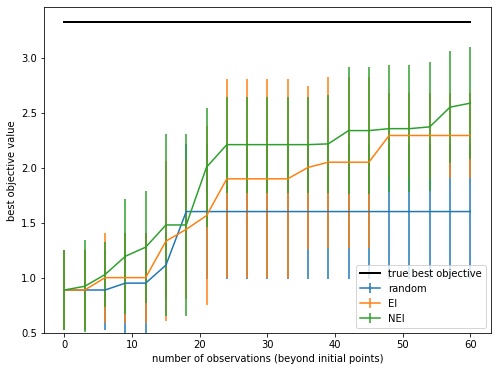

In [15]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(numTrials)

global_maximum = neg_hartmann6.optimal_value

iters = np.arange(numBatches + 1) * batch_sz
y_EI = np.asarray(best_observed_all_EI)
y_NEI = np.asarray(best_observed_all_NEI)
y_rand = np.asarray(best_random_all)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(iters, y_rand.mean(axis=0), yerr=ci(y_rand), label="random", linewidth=1.5)
ax.errorbar(iters, y_EI.mean(axis=0), yerr=ci(y_EI), label="EI", linewidth=1.5)
ax.errorbar(iters, y_NEI.mean(axis=0), yerr=ci(y_NEI), label="NEI", linewidth=1.5)
plt.plot([0, numBatches * batch_sz], [global_maximum] * 2, 'k', label="true best objective", linewidth=2)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")

## Follow-up questions

### A.

Do you feel you understood the decisions made throughout this entire tutorial and the reasoning behind them? If not, which parts seemed unclear to you? Which part of the entire tutorial was the most confusing?


### B.

How does adding a synthetic constraint to the objective function make this example more like real Bayesian Optimization applications?


### C.

Why did Noisy Expected Improvement outperform exact Expected Improvement in this example?




